In [ ]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup

In [ ]:
#@title Installs
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-datasets==4.8 --quiet #8
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install transformers==4.17 --quiet #4.40.2 #4.37.2
!pip install pyyaml h5py

In [ ]:
#@title Imports

import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import transformers

from tensorflow.keras.optimizers import Adam
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification

from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig, TFRobertaForSequenceClassification
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig, TFDistilBertForSequenceClassification
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoConfig

from transformers import logging
logging.set_verbosity_error()

import matplotlib.pyplot as plt
import seaborn as sns


import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score


import re

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

In [ ]:
#@title Global tunable parameters

# Sequence length to truncate/pad
MAX_SEQUENCE_LENGTH = 1000 #800

# hidden layer size after BERT's ouput
HIDDEN_LAYER_SIZE = 100

# Max embeddings in BERT
BERT_MAX_EMBEDDINGS = 1024 #1024
ROBERTA_MAX_EMBEDDINGS = 1024 #1024
DISTILBERT_MAX_EMBEDDINGS = 512 #1024

# fraction of data to use for training
FRACTION = 0.1

# Base path to store trained snapshot and results
BASE_PATH = 'drive/MyDrive/MIDS-266/w266/project/'

# Utility library

In [ ]:
#@title Utility print function

def print_version(library_name):
    try:
        lib = __import__(library_name)
        version = getattr(lib, '__version__', 'Version number not found')
        print(f"{library_name} version: {version}")
    except ImportError:
        print(f"{library_name} not installed.")
    except Exception as e:
        print(f"An error occurred: {e}")

#confirm versions
print_version('numpy')
print_version('transformers')
print_version('tensorflow')
print_version('keras')
print_version('pandas')
print_version('sklearn')

numpy version: 1.26.4
transformers version: 4.17.0
tensorflow version: 2.15.0
keras version: 2.15.0
pandas version: 2.1.4
sklearn version: 1.3.2


In [ ]:
#@title Utility Plot Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
        if 'classification_%s' % metric in model_history2.history:
            metric2 = 'classification_%s' % metric
        else:
            metric2 = metric

        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric2])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric2])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            model_metric = [metric, metric2][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[model_metric])
            ax1.plot(model_history.history['val_%s' % model_metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

# Dataset preparation

In [ ]:
#@title Read Reddit dataset into a dataframe

print('Select training filename in Reddit directory')
print(' 1. both_train.csv')
print(' 2. combo_train.csv')
print(' 3. posts_train.csv')
print(' 4. titles_train.csv')
print(' 5. both_train_masked.csv')
print('Enter choice [1]:  ')

file_input = input()
if file_input == "":
  file_input = int(1)
else:
  file_input = int(file_input)
  if file_input < 1 or file_input > 5:
    file_input = 1

match file_input:
      case 1:
          file_choice = 'both_train.csv'
          val_choice = 'both_val.csv'

      case 2:
          file_choice = 'combo_train.csv'
          val_choice = 'combo_val.csv'

      case 3:
          file_choice = 'posts_train.csv'
          val_choice = 'posts_val.csv'

      case 4:
          file_choice = 'titles_train.csv'
          val_choice = 'titles_val.csv'

      case 5:
          file_choice = 'both_train_masked.csv'
          val_choice = 'both_val_masked.csv'

      case '':
          file_choice = 'both_train.csv'
          val_choice = 'both_val.csv'

      case _:
          file_choice = 'both_train.csv'
          val_choice = 'both_val.csv'

rdt_trainfile = f'{BASE_PATH}/Reddit/{file_choice}'
print(f'Using Train file: {rdt_trainfile}')
rdt_valfile = f'{BASE_PATH}/Reddit/{val_choice}'
print(f'Using Val file: {rdt_valfile}')

print('Select test filename in Reddit directory')
print(' 1. both_test.csv')
print(' 2. both_test_masked.csv')
print('Enter choice [1]:  ')

file_input = input()
if file_input == "":
  file_input = int(1)
else:
  file_input = int(file_input)
  if file_input < 1 or file_input > 2:
    file_input = 1

match file_input:
      case 1:
          file_choice = 'both_test.csv'

      case 2:
          file_choice = 'both_test_masked.csv'

      case '':
          file_choice = 'both_test.csv'

      case _:
          file_choice = 'both_test.csv'

rdt_testfile = f'{BASE_PATH}/Reddit/{file_choice}'
print(f'Using Test file: {rdt_testfile}')

rdt_train = pd.read_csv(rdt_trainfile)
rdt_test = pd.read_csv(rdt_testfile)
rdt_val = pd.read_csv(rdt_valfile)

rdt_train['combined'] = rdt_train["title"].astype(str) + ' ' + rdt_train["post"].astype(str)
rdt_test['combined'] = rdt_test["title"].astype(str) + ' ' + rdt_test["post"].astype(str)
rdt_val['combined'] = rdt_val["title"].astype(str) + ' ' + rdt_val["post"].astype(str)


# Shuffle all rows
rdt_train = rdt_train.sample(frac=1).reset_index(drop=True)
rdt_test = rdt_test.sample(frac=1).reset_index(drop=True)
rdt_val = rdt_val.sample(frac=1).reset_index(drop=True)


X_train = rdt_train.combined
X_val = rdt_val.combined
X_test = rdt_test.combined
y_train = rdt_train.class_id
y_val = rdt_val.class_id
y_test = rdt_test.class_id

train_labels = np.array(y_train)
test_labels = np.array(y_test)
val_labels = np.array(y_val)

train_examples_list = []
test_examples_list = []
val_examples_list = []

temp_train_examples = np.array(X_train)
temp_test_examples = np.array(X_test)
temp_val_examples = np.array(X_val)

for i in range(len(temp_train_examples)):
  size = len(temp_train_examples[i])
  lower = int(0.3*MAX_SEQUENCE_LENGTH)
  upper = int(0.7*MAX_SEQUENCE_LENGTH)
  if size > MAX_SEQUENCE_LENGTH:
    train_examples_list.append(temp_train_examples[i][:lower] + temp_train_examples[i][upper:])
  else:
    train_examples_list.append(temp_train_examples[i])

for i in range(len(temp_test_examples)):
  size = len(temp_test_examples[i])
  lower = int(0.3*MAX_SEQUENCE_LENGTH)
  upper = int(0.7*MAX_SEQUENCE_LENGTH)
  if size > MAX_SEQUENCE_LENGTH:
    test_examples_list.append(temp_test_examples[i][:lower] + temp_test_examples[i][upper:])
  else:
    test_examples_list.append(temp_test_examples[i])

for i in range(len(temp_val_examples)):
  size = len(temp_val_examples[i])
  lower = int(0.3*MAX_SEQUENCE_LENGTH)
  upper = int(0.7*MAX_SEQUENCE_LENGTH)
  if size > MAX_SEQUENCE_LENGTH:
    val_examples_list.append(temp_val_examples[i][:lower] + temp_val_examples[i][upper:])
  else:
    val_examples_list.append(temp_val_examples[i])

train_examples = np.array(train_examples_list)
test_examples = np.array(test_examples_list)
val_examples = np.array(val_examples_list)


Select training filename in Reddit directory
 1. both_train.csv
 2. combo_train.csv
 3. posts_train.csv
 4. titles_train.csv
 5. both_train_masked.csv
Enter choice [1]:  
1
Using Train file: drive/MyDrive/MIDS-266/w266/project//Reddit/both_train.csv
Using Val file: drive/MyDrive/MIDS-266/w266/project//Reddit/both_val.csv
Select test filename in Reddit directory
 1. both_test.csv
 2. both_test_masked.csv
Enter choice [1]:  
2
Using Test file: drive/MyDrive/MIDS-266/w266/project//Reddit/both_test_masked.csv


In [ ]:
rdt_train[10:13].post

,post
10,"last summer i was hypomanic. this summer i've been depressed. everything is hot and sticky and intolerable. the sun is too bright and i panic thinking of all the wonderful times outside i'm missing out on; i get even more confused, depressed, lonely, and dissociative. lots of triggers are beginning to bring up a past trauma. nighttime is the worst- the heat and the cicadas and the sleeplessness despite heavy medication. hope all of you who are depressed this summer are doing ok."
11,"reading through the posts on this sub literally have me crying on my break at class. i had no idea that all of these other symptoms were a part of adhd, for 18 years i've just thought there was something wrong with me and i was alone in these feelings. the constant muscle tension, the dysphoria, the way that you start daydreaming no matter how hard you try to pay attention. my family doesn't understand that there's more to the disorder than being hyper and that no, no matter how hard i try i cannot always keep it under control, and doing so makes me an anxious irritable wreck. this sub made me realize i'm not alone in the world with these feelings, and it's so nice :) thank you guys"
12,"with some time to spare! edit: this sub is amazing. thank you for the encouragement and sharing ur struggles too! its not easy for my adhd brain to reward myself for this, but you guys are really helping!"


In [ ]:
print(rdt_train.class_name.unique())
rdt_train.class_id.unique()

['bipolar' 'ptsd' 'anxiety' 'none' 'adhd' 'depression']


array([2, 4, 1, 5, 0, 3])

In [ ]:
rdt_train

,ID,title,post,class_name,class_id,combined
0,899f4d0e-5c44-4b53-9566-5c39872f9a15,college is unbelievably hard for me.,"hello, i am a recently diagnosed bipolar ii an...",bipolar,2,"college is unbelievably hard for me. hello, i ..."
1,6776e3ea-02b6-4aee-bd24-ec144da94b0f,does anyone else hear the voice of their abuser?,i can’t make my mother’s voice leave me alone....,ptsd,4,does anyone else hear the voice of their abuse...
2,51efd39e-48c6-4624-8651-1f94ed7e437f,has anyone else looked up/searched for their a...,"last night, i don’t know why, but i spent a lo...",ptsd,4,has anyone else looked up/searched for their a...
3,7e93c9d8-7107-4cf3-a63e-89dc821bce29,late 20's and i'm lying in my closet right now,i have general anxiety and i often get the urg...,anxiety,1,late 20's and i'm lying in my closet right now...
4,e4e81256-cb74-4dde-833a-184c15a274b1,can we talk about pmsing and ptsd?,"at this point in my recovery, i can get throug...",ptsd,4,can we talk about pmsing and ptsd? at this poi...
...,...,...,...,...,...,...
13722,89458624-fa75-4f21-97ad-11ff0510c23c,do you ever feel like something is wrong?,"like you are in your house, nothing is bad, ev...",anxiety,1,do you ever feel like something is wrong? like...
13723,a8322429-0e6c-46fe-80f5-04cc6745758b,i washed a pot,"it was nasty, cruddy, and in the sink for thre...",bipolar,2,"i washed a pot it was nasty, cruddy, and in th..."
13724,7c540c97-d6b8-40ae-8859-37c9f16e9d4c,"don't want to die, just want to stop existing.","last time i felt like this, i just wanted a br...",depression,3,"don't want to die, just want to stop existing...."
13725,a400d177-74a8-443e-9716-7b95b4b3bde3,"deezer.com 10,406,168 artist db","deezer.com 10,406,168 artist db we have scrape...",none,5,"deezer.com 10,406,168 artist db deezer.com 10,..."


In [ ]:
test_examples[30]

"does anyone have trouble sitting still and have to occupy yourself? i can't sit still when i get my eyebrows done, and when i'm in class i usually doodle to focus. i pay attention very well in school regardless of that, and drawing helps me focus."

In [ ]:
test_labels[30]

1

In [ ]:
#@title Inspect data and label characteristics

print(f'Training set labels shape: {train_labels.shape}')
print(f'Validation set labels shape: {val_labels.shape}')
print(f'Test set labels shape: {test_labels.shape}')

print(f'Training set examples shape: {train_examples.shape}')
print(f'Validation set examples shape: {val_examples.shape}')
print(f'Test set examples shape: {test_examples.shape}')

print(f'Distribution of the length of all title')
print(rdt_train["title"].str.len().describe())

print('Distribution of the length of all posts')
print(rdt_train["post"].str.len().describe())

print(f'Labels min : {rdt_train.class_id.min()} max : {rdt_train.class_id.max()}')


Training set labels shape: (13727,)
Validation set labels shape: (1488,)
Test set labels shape: (1488,)
Training set examples shape: (13727,)
Validation set examples shape: (1488,)
Test set examples shape: (1488,)
Distribution of the length of all title
count    13727.000000
mean        67.111751
std         48.713468
min          2.000000
25%         34.000000
50%         54.000000
75%         85.000000
max        306.000000
Name: title, dtype: float64
Distribution of the length of all posts
count    13727.000000
mean      1065.297734
std       1373.414370
min        123.000000
25%        362.000000
50%        658.000000
75%       1236.500000
max      38168.000000
Name: post, dtype: float64
Labels min : 0 max : 5


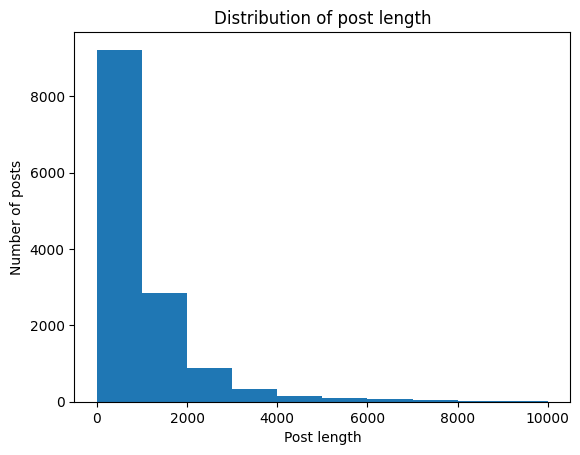

In [ ]:
#@ Histogram of all post length
plt.hist(rdt_train["post"].str.len(), bins=10, range=(0, 10000))
plt.title('Distribution of post length')
plt.xlabel('Post length')
plt.ylabel('Number of posts')
plt.show()

In [ ]:
#@title Distribution of labels in training and test sets
for i in range(np.max(train_labels)):
  pos_indices = np.where(train_labels == i)
  pct_positive = len(pos_indices[0])/len(train_labels)
  print(f'Labels {i} in training set: {len(pos_indices[0])}/{len(train_labels)} ({pct_positive})')

for i in range(np.max(val_labels)):
  pos_indices = np.where(val_labels == i)
  pct_positive = len(pos_indices[0])/len(val_labels)
  print(f'Labels {i} in validation set: {len(pos_indices[0])}/{len(val_labels)} ({pct_positive})')

for i in range(np.max(test_labels)):
  pos_indices = np.where(test_labels == i)
  pct_positive = len(pos_indices[0])/len(test_labels)
  print(f'Labels {i} in test set: {len(pos_indices[0])}/{len(test_labels)} ({pct_positive})')


Labels 0 in training set: 2465/13727 (0.17957310410140598)
Labels 1 in training set: 2422/13727 (0.17644059153493116)
Labels 2 in training set: 2407/13727 (0.17534785459313762)
Labels 3 in training set: 2450/13727 (0.17848036715961244)
Labels 4 in training set: 2001/13727 (0.14577110803525897)
Labels 0 in validation set: 248/1488 (0.16666666666666666)
Labels 1 in validation set: 248/1488 (0.16666666666666666)
Labels 2 in validation set: 248/1488 (0.16666666666666666)
Labels 3 in validation set: 248/1488 (0.16666666666666666)
Labels 4 in validation set: 248/1488 (0.16666666666666666)
Labels 0 in test set: 248/1488 (0.16666666666666666)
Labels 1 in test set: 248/1488 (0.16666666666666666)
Labels 2 in test set: 248/1488 (0.16666666666666666)
Labels 3 in test set: 248/1488 (0.16666666666666666)
Labels 4 in test set: 248/1488 (0.16666666666666666)


In [ ]:
mh_cls_names = list(rdt_train.class_name.unique())
mh_cls_names
mh_cls_id = list(rdt_train.class_id.unique())
mh_cls_id

mh_dict_id_to_name = {}
mh_dict_name_to_id = {}
for idx, value in enumerate(mh_cls_id):
    mh_dict_id_to_name[value] = mh_cls_names[idx]
for idx, value in enumerate(mh_cls_names):
    mh_dict_name_to_id[value] = mh_cls_id[idx]

print(mh_dict_id_to_name)
print(mh_dict_name_to_id)


{2: 'bipolar', 4: 'ptsd', 1: 'anxiety', 5: 'none', 0: 'adhd', 3: 'depression'}
{'bipolar': 2, 'ptsd': 4, 'anxiety': 1, 'none': 5, 'adhd': 0, 'depression': 3}


In [ ]:
rdt_train.class_name.unique()

array(['bipolar', 'ptsd', 'anxiety', 'none', 'adhd', 'depression'],
      dtype=object)

In [ ]:
#@title BERT Tokenization of training, validation and test data

def tokenize_train_val(tokenizer, train_examples, val_examples):

    train_examples_str = [x for x in train_examples]
    val_examples_str = [x for x in val_examples]

    # Tokenize training, validation and test data
    bert_train_tokenized = tokenize_data(tokenizer, train_examples_str)
    bert_val_tokenized = tokenize_data(tokenizer, val_examples_str)

    bert_train_inputs = [bert_train_tokenized.input_ids,
                        bert_train_tokenized.token_type_ids,
                        bert_train_tokenized.attention_mask]


    bert_val_inputs = [bert_val_tokenized.input_ids,
                        bert_val_tokenized.token_type_ids,
                        bert_val_tokenized.attention_mask]


    return bert_train_inputs, bert_val_inputs

In [ ]:
def tokenize_data(tokenizer, input_str):
  tokenized = tokenizer(input_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
  return tokenized

# BERT Model

In [ ]:
#@title BERT Tokenization of training, validation and test data

def tokenize_test(tokenizer, test_examples):

    test_examples_str = [x for x in test_examples]

    # Tokenize training, validation and test data
    bert_test_tokenized = tokenize_data(tokenizer, test_examples_str)

    bert_test_inputs = [bert_test_tokenized.input_ids,
                        bert_test_tokenized.token_type_ids,
                        bert_test_tokenized.attention_mask]


    return bert_test_inputs

In [ ]:

#@title Train BERT model using CLS token
def create_bert_cls_model(bert_base_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """

    bert_base_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    #bert_out = bert_base_model(bert_inputs)
    bert_out = bert_base_model.bert([input_ids, attention_mask, token_type_ids])

    # The first token of every example is a CLS token
    cls_embedding = bert_out[0][:, 0, :]
    print(cls_embedding.shape)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_embedding)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(6, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model


def bert_main(train, val, tlabels, vlabels, fraction):
    """
    Main function to train BERT model
    """
    # Load BERT model
    config_l = BertConfig.from_pretrained("bert-base-cased")
    config_l.num_max_position_embeddingslabels = BERT_MAX_EMBEDDINGS
    bert_model = TFBertModel.from_pretrained('bert-base-cased', config = config_l)

    # Load training, validation and test data
    train_samples = train[0:int(fraction*len(train))]
    val_samples = val[0:int(fraction*len(val))]

    # Tokenize training, validation and test data
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    bert_train_inputs, bert_val_inputs = tokenize_train_val(bert_tokenizer, train_samples, val_samples)

    # Convert labels to numpy arrays
    bert_train_labels = np.array(tlabels)
    bert_train_sample_labels = bert_train_labels[0:int(fraction*len(tlabels))]

    bert_val_labels = np.array(vlabels)
    bert_val_sample_labels = bert_val_labels[0:int(fraction*len(vlabels))]

    # Create classification model
    bert_avg_model = create_bert_cls_model(bert_model, hidden_size=HIDDEN_LAYER_SIZE)

    bert_avg_model.summary()

    early_stop_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=2, verbose=1)

    bert_avg_model_history = bert_avg_model.fit(
        bert_train_inputs,
        bert_train_sample_labels,
        validation_data=(bert_val_inputs, bert_val_sample_labels),
        batch_size=12,
        epochs=2,
        callbacks=[early_stop_callback])

    return bert_avg_model, bert_avg_model_history

# Distilbert

In [ ]:


def distilbert_main(train, val, tlabels, vlabels, fraction,
                    max_sequence_length=MAX_SEQUENCE_LENGTH,
                    hidden_size = 100,
                    dropout=0.3,
                    learning_rate=0.00005):
    """
    Main function to train distilbert model
    """

    LEARNING_RATE = 5e-5
    BATCH_SIZE = 8
    NUM_EPOCHS = 2

    NUM_LABELS = np.max(tlabels) + 1

    config_l = DistilBertConfig.from_pretrained("distilbert-base-uncased")
    config_l.num_max_position_embeddingslabels = DISTILBERT_MAX_EMBEDDINGS
    config_l.num_labels = NUM_LABELS
    base_model = TFDistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased', config = config_l)
    #base_model = TFDistilBertForSequenceClassification.from_pretrained(
    #    'distilbert-base-uncased', num_labels = NUM_LABELS)

    # Load training, validation and test data
    tsamples = train[0:int(fraction*len(train))]
    train_samples = tsamples.tolist()
    vsamples = val[0:int(fraction*len(val))]
    val_samples = vsamples.tolist()

    # Convert labels to numpy arrays
    train_labels = np.array(tlabels)
    train_sample_labels = train_labels[0:int(fraction*len(tlabels))]

    val_labels = np.array(vlabels)
    val_sample_labels = val_labels[0:int(fraction*len(vlabels))]

    # Tokenize training, validation and test data
    distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(tokenize_data(distilbert_tokenizer, train_samples)),  # Convert BatchEncoding instance to dictionary
        train_sample_labels)).shuffle(1000).batch(BATCH_SIZE).prefetch(1)

    val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(tokenize_data(distilbert_tokenizer, val_samples)),  # Convert BatchEncoding instance to dictionary
        val_sample_labels)).batch(BATCH_SIZE).prefetch(1)

    base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                 metrics='accuracy')

    base_model.summary()

    model_history = base_model.fit(
        train_dataset,
        y=None,
        validation_data=val_dataset,
        batch_size=BATCH_SIZE,
        epochs=NUM_EPOCHS)

    return base_model, model_history



# Roberta

In [ ]:
#@title BERT Tokenization of training, validation and test data

def roberta_tokenize_train_val(tokenizer, train_examples, val_examples):

    train_examples_str = [x for x in train_examples]
    val_examples_str = [x for x in val_examples]

    # Tokenize training, validation and test data
    train_tokenized = tokenize_data(tokenizer, train_examples_str)
    val_tokenized = tokenize_data(tokenizer, val_examples_str)

    train_inputs = [train_tokenized.input_ids,
                        train_tokenized.attention_mask]


    val_inputs = [val_tokenized.input_ids,
                        val_tokenized.attention_mask]


    return train_inputs, val_inputs

In [ ]:
#@title Train RoBERTa model - use CLS token
def create_roberta_cls_model(base_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """

    base_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    #token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    inputs = {'input_ids': input_ids,
              'attention_mask': attention_mask}

    #roberta_out = base_model(inputs)
    roberta_out = base_model.roberta([input_ids, attention_mask])

    # The first token of every example is a CLS token
    cls_embedding = roberta_out[0][:, 0, :]
    print(cls_embedding.shape)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_embedding)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(6, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model




In [ ]:
def roberta_main(train, val, tlabels, vlabels, fraction):
    """
    Main function to train RoBerta model
    """

    # Load training, validation and test data
    tsamples = train[0:int(fraction*len(train))]
    vsamples = val[0:int(fraction*len(val))]

    train_samples = tsamples
    val_samples = vsamples

    # Tokenize training, validation and test data
    roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    roberta_train_inputs, roberta_val_inputs = roberta_tokenize_train_val(roberta_tokenizer, train_samples, val_samples)

    # Convert labels to numpy arrays
    roberta_train_labels = np.array(tlabels)
    roberta_train_sample_labels = roberta_train_labels[0:int(fraction*len(tlabels))]

    roberta_val_labels = np.array(vlabels)
    roberta_val_sample_labels = roberta_val_labels[0:int(fraction*len(vlabels))]

    # Create classification model
    config_l = RobertaConfig.from_pretrained("roberta-base")
    config_l.num_max_position_embeddingslabels = ROBERTA_MAX_EMBEDDINGS

    roberta_model = TFRobertaModel.from_pretrained('roberta-base', config = config_l)
    roberta_classification_model = create_roberta_cls_model(roberta_model, hidden_size=HIDDEN_LAYER_SIZE)

    roberta_classification_model.summary()

    roberta_classification_model_history = roberta_classification_model.fit(
        roberta_train_inputs,
        roberta_train_sample_labels,
        validation_data=(roberta_val_inputs, roberta_val_sample_labels),
        batch_size=8,
        epochs=2
    )

    return roberta_classification_model, roberta_classification_model_history


# Main Control loop


Task selection menu
What task do you want to do [default: 7]:
1. Load my fine tuned reddit posts model
2. Train (fine-tune) a base model
3. Run prediction on test dataset [selected file: drive/MyDrive/MIDS-266/w266/project//Reddit/both_test_masked.csv]
4. Plot Confusion matrix and classification reports on last prediction results
5. Save mismatched predictions
6. Delete last model and history
7. Quit
2

Enter the type of model to train [default: 3]: 
1. BERT with custom classifier
2. Distilbert
3. Roberta
4. None
1
Enter the fraction in range (0.0-1.0) of training data to use [0.1]: 
1
	Training model 1 with fraction 1.0
(None, 768)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids_layer (InputLaye  [(None, 1000)]               0         []                            
 r)                                           

1144/1144 [==============================] - 862s 718ms/step - loss: 0.7081 - accuracy: 0.7642 - val_loss: 0.5055 - val_accuracy: 0.8293
Epoch 2/2
1144/1144 [==============================] - 819s 716ms/step - loss: 0.4299 - accuracy: 0.8612 - val_loss: 0.4943 - val_accuracy: 0.8380
Saving model to drive/MyDrive/MIDS-266/w266/project/saved_models/1

Task selection menu
What task do you want to do [default: 7]:
1. Load my fine tuned reddit posts model
2. Train (fine-tune) a base model
3. Run prediction on test dataset [selected file: drive/MyDrive/MIDS-266/w266/project//Reddit/both_test_masked.csv]
4. Plot Confusion matrix and classification reports on last prediction results
5. Save mismatched predictions
6. Delete last model and history
7. Quit
3
	Predicting on test set for model_type 1
47/47 [==============================] - 29s 559ms/step

Task selection menu
What task do you want to do [default: 7]:
1. Load my fine tuned reddit posts model
2. Train (fine-tune) a base model
3. Run 

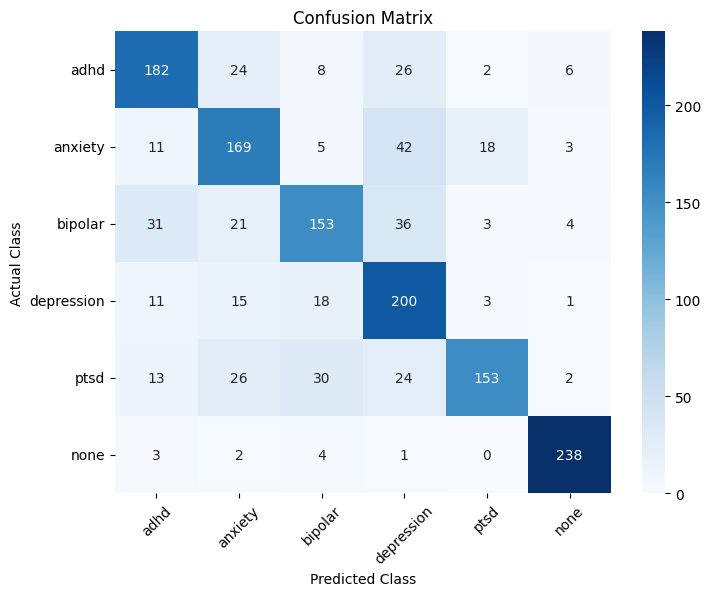

Accuracy: 0.7358870967741935
              precision    recall  f1-score   support

        adhd       0.73      0.73      0.73       248
     anxiety       0.66      0.68      0.67       248
     bipolar       0.70      0.62      0.66       248
  depression       0.61      0.81      0.69       248
        ptsd       0.85      0.62      0.72       248
        none       0.94      0.96      0.95       248

    accuracy                           0.74      1488
   macro avg       0.75      0.74      0.74      1488
weighted avg       0.75      0.74      0.74      1488


Task selection menu
What task do you want to do [default: 7]:
1. Load my fine tuned reddit posts model
2. Train (fine-tune) a base model
3. Run prediction on test dataset [selected file: drive/MyDrive/MIDS-266/w266/project//Reddit/both_test_masked.csv]
4. Plot Confusion matrix and classification reports on last prediction results
5. Save mismatched predictions
6. Delete last model and history
7. Quit


In [ ]:
def train(train_examples, val_examples, train_labels, val_labels, fraction, input_model):
  match input_model:
      case 1:
          model, model_history = bert_main(train_examples, val_examples, train_labels, val_labels, fraction)

      case 2:
          model, model_history = distilbert_main(train_examples, val_examples, train_labels, val_labels, fraction)

      case 3:
          model, model_history = roberta_main(train_examples, val_examples, train_labels, val_labels, fraction)

      case 4:
          roberta_attention_main()

      case _:
          print("Invalid input")

  # Save the model
  path = f'drive/MyDrive/MIDS-266/w266/project/saved_models/{input_model}'
  if not os.path.exists(path):
    os.makedirs(path, exist_ok=True)
  print(f'Saving model to {path}')
  tf.keras.models.save_model(model, path)
  #model.save(f'{path}/model.keras')

  return model, model_history

def predict(test_examples, test_labels, model_type, model):
  """
  Test the model on the test set
  """

  from sklearn.metrics import confusion_matrix

  #Predict
  print(f'\tPredicting on test set for model_type {model_type}')
  match model_type:
      case 1:
        bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
        test_tokens = tokenize_test(bert_tokenizer, test_examples)
        y_prediction = model.predict(test_tokens)

      case 2:
        distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
        test_examples_list = test_examples.tolist()
        test_tokens = tokenize_data(distilbert_tokenizer, test_examples_list)
        y_prediction = model.predict((dict(test_tokens),)) # Pass a tuple to predict
        # Extract the NumPy array from the dictionary
        y_prediction = y_prediction[0] # Extract the NumPy array
        # The model expects only input_ids, not a dictionary
        #y_prediction = model.predict(test_tokens['input_ids'], test_tokens['attention_mask'])  # Pass only input_ids


      case 3:
        roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        test_examples_list = test_examples.tolist()
        test_tokens = tokenize_data(roberta_tokenizer, test_examples_list)
        y_prediction = model.predict((test_tokens['input_ids'], test_tokens['attention_mask']))

  # Convert predicted probabilities to class labels
  y_pred_label = np.argmax(y_prediction, axis=1) # Convert probabilities to discrete class labels

  return y_pred_label, y_prediction

def confusion_matrix_plot(test_labels, y_prediction):
  """
  Plot the confusion matrix
  """
  print('\t Printing confusion matrix')
  #Create confusion matrix and normalizes it over predicted (columns)
  result = confusion_matrix(test_labels, y_prediction)

  # Plot the confusion matrix
  actuals_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]
  predictions_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]

  # Plot the confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(result, annot=True, fmt='d', cmap='Blues')

  # Add string labels to the axes
  plt.xticks(ticks=np.arange(len(actuals_names)) + 0.5, labels=actuals_names, rotation=45)
  plt.yticks(ticks=np.arange(len(predictions_names)) + 0.5, labels=predictions_names, rotation=0)

  # Add labels, title, and color bar
  plt.ylabel('Actual Class')
  plt.xlabel('Predicted Class')
  plt.title('Confusion Matrix')
  plt.show()

  print(f'Accuracy: {accuracy_score(test_labels, y_prediction)}')

  print(classification_report(test_labels, y_prediction, target_names=predictions_names))

  return


def train_model():
  print('\nEnter the type of model to train [default: 3]: ')
  print('1. BERT with custom classifier')
  print('2. Distilbert')
  print('3. Roberta')
  print('4. None')

  model_type = input()
  if model_type == '':
    model_type = 3
  model_type = int(model_type)

  if model_type > 3:
    print('Invalid input')
    return

  print('Enter the fraction in range (0.0-1.0) of training data to use [0.1]: ')
  fraction = input()
  if fraction == '':
    fraction = FRACTION
  fraction = float(fraction)

  if fraction > 1:
    print('Invalid input')
    return

  print(f'\tTraining model {model_type} with fraction {fraction}')
  model, model_history = train(train_examples, val_examples, \
                               train_labels, val_labels, \
                               fraction, model_type)

  return model, model_type, model_history

def load_my_model():

  print('\nEnter my custom saved model based of: ')
  print('1. BERT with custom classifier')
  print('2. Distilbert')
  print('3. Roberta')
  print('4. Roberta with Attention')
  model_type = input()
  model_type = int(model_type)

  if model_type > 4:
    print('Invalid input')
    return
  path = f'{BASE_PATH}/saved_models/{model_type}'
  if not os.path.exists(path):
    print('Model not found')
    return

  print(f'\tLoading model from {path}')
  lmodel = keras.models.load_model(path)

  return lmodel,model_type


if __name__ == '__main__':
  last_model = None
  last_model_type = 0
  last_model_history = None
  predicted_labels = None
  y_pred = None

  while True:
      print('\nTask selection menu')
      print('What task do you want to do [default: 7]:')
      print('1. Load my fine tuned reddit posts model')
      print('2. Train (fine-tune) a base model')
      print(f'3. Run prediction on test dataset [selected file: {rdt_testfile}]')
      print('4. Plot Confusion matrix and classification reports on last prediction results')
      print('5. Save mismatched predictions')
      print('6. Delete last model and history')
      print('7. Quit')

      task = input()
      if task == '' :
        task = '7'

      task = int(task)
      if task > 7:
        print(f'\tInvalid input {task}')
        continue

      match(task):
        case 1:
          last_model, last_model_type = load_my_model()
          last_model.summary()

        case 2:
          last_model, last_model_type, last_model_history = train_model()

        case 3:
          if last_model is None or last_model_type == 0:
            print('\tModel not loaded; Load (option1) or train (option2) a model ')
            continue
          predicted_labels, y_pred = predict(test_examples, test_labels, last_model_type, last_model)

        case 4:
          if predicted_labels is None:
            print('\tRun predictions using option3 before plotting confusion matrix')
            continue
          confusion_matrix_plot(test_labels, predicted_labels)

        case 5:
          if predicted_labels is None:
            print('\tRun predictions using option3 before printing mismatches')
            continue

          filename = f'{BASE_PATH}/saved_models/{last_model_type}/mismatches.csv'
          print(f'\tSaving mismatches to {filename}')
          actuals_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]
          predictions_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]
          mismatches = []
          for i in range(len(test_labels)):
              if True:
              #if test_labels[i] != predicted_labels[i]:
                  id1 = test_labels[i]
                  id2 = predicted_labels[i]
                  entry = {}
                  entry['actual'] = actuals_names[id1]
                  entry['predicted'] = predictions_names[id2]
                  entry['test_id'] = i
                  entry['text'] = test_examples[i]
                  y_probs = y_pred[i]
                  for j in range(len(y_probs)):
                    entry[f'prob_{actuals_names[j]}'] = y_probs[j]
                  mismatches.append(entry)
          df = pd.DataFrame(mismatches)
          df.to_csv(filename, index=False)
          print(f'\tSaved mismatches to {filename}')

        case 6:
            import gc

            gc.collect()
            if last_model is None:
              print('\tNo model to delete')
              continue

            print(f'\tDeleting model {last_model_type}')
            del(last_model)
            del(last_model_history)
            del(predicted_labels)
            last_model = None
            last_model_type = 0
            last_model_history = None
            predicted_labels = None
            print('\tModel deleted')
            continue

        case 7:
          print('\tQuitting')
          break


        case _:
          print('\tInvalid input')
          break



In [ ]:
last_model_history

In [ ]:
plt.plot(last_model_history.history['accuracy'])
plt.plot(last_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(last_model_history.history['loss'])
plt.plot(last_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

pd.DataFrame(last_model_history.history).plot(figsize=(8,5))
plt.show()


In [ ]:
pd.DataFrame(last_model_history.history)

In [ ]:
!ls /content/drive/MyDrive/MIDS-266/w266/project/saved_models/
